In [2]:
import os
import pandas as pd
import random
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
import seaborn as sns
from sklearn.model_selection import GroupKFold,StratifiedKFold
import matplotlib.pyplot as plt
sns.set()
import numpy as np
from tqdm.notebook import tqdm
import glob

In [14]:
images = glob.glob("UTKFace/*.jpg")

In [16]:
images[0]

'UTKFace/39_1_0_20170103183459755.jpg.chip.jpg'

In [21]:
def gen_pd(paths):
    data = pd.DataFrame(index=np.arange(len(paths)),columns=['path','age','gender','ethnicity'])
    #pbar = tqdm(enumerate(paths),total=len(paths))
    with tqdm(total=len(paths)) as bar:
        for i, ele in enumerate(paths):
            data.loc[i,'path'] = ele
            data.loc[i,'age'] = ele.split("/")[1].split("_")[0]
            data.loc[i,'gender'] = ele.split("/")[1].split("_")[1]
            data.loc[i,'ethnicity'] = ele.split("/")[1].split("_")[2]
            bar.update(1)
    return data

In [22]:
df = gen_pd(images)

In [34]:
df.to_csv("UTK.csv")

/home/lustbeast/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ethnicity', ylabel='Density'>

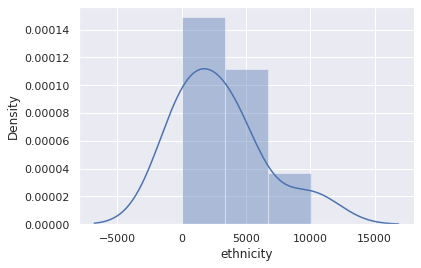

In [33]:
sns.distplot(df.ethnicity.value_counts())

In [46]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices


In [65]:
groups = df.ethnicity.values
y = df.gender.values
x = df.path.values
df['folds'] = -1

In [66]:
for i ,(train_ind,val_ind) in enumerate(StratifiedKFold(n_splits=5).split(x,y)):
    df.loc[val_ind,'folds'] = i

In [67]:
df.to_csv("UTK.csv")

In [68]:
df

,path,age,gender,ethnicity,folds
0,UTKFace/39_1_0_20170103183459755.jpg.chip.jpg,39,1,0,0
1,UTKFace/26_0_0_20170117144704233.jpg.chip.jpg,26,0,0,0
2,UTKFace/24_0_3_20170119164647197.jpg.chip.jpg,24,0,3,0
3,UTKFace/22_0_1_20170113133336209.jpg.chip.jpg,22,0,1,0
4,UTKFace/23_1_4_20170103223558799.jpg.chip.jpg,23,1,4,0
...,...,...,...,...,...
23703,UTKFace/26_1_0_20170116184651548.jpg.chip.jpg,26,1,0,4
23704,UTKFace/38_0_3_20170117121006148.jpg.chip.jpg,38,0,3,4
23705,UTKFace/79_0_0_20170111222432817.jpg.chip.jpg,79,0,0,4
23706,UTKFace/68_0_1_20170113181302934.jpg.chip.jpg,68,0,1,4


In [72]:
import cv2
  
  
# define a video capture object
vid = cv2.VideoCapture(0)
  
while(True):
      
    # Capture the video frame
    # by frame
    ret, frame = vid.read()
  
    # Display the resulting frame
    cv2.imshow('frame', frame)
      
    # the 'q' button is set as the
    # quitting button you may use any
    # desired button of your choice
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
  
# After the loop release the cap object
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()

error: OpenCV(4.4.0) /tmp/pip-req-build-h2062vqd/opencv/modules/highgui/src/window.cpp:651: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'
